In [ ]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

from scatseisnet import ScatteringNetwork

%config InlineBackend.figure_format = "svg"

# parameter

Pour obtenir plus de coefficients, il suffit d'augmenter la résolution (qui détermine le nombre de wavelets par octave). Par exemple, pour la première couche, on obtient un total de 40 wavelets. Les divisions d'octave sont appliquées sur la bande de fréquence commençant à 5 Hz. Voici un exemple de paramètres pour les banques de filtres :

```python
bank_keyword_arguments = (
    {"octaves": 4, "resolution": 10, "quality": 1},
    {"octaves": 5, "resolution": 5 , "quality": 3},
)


In [2]:
segment_duration_seconds = 20.0 # analyse de 20 seconde par bin 
sampling_rate_hertz = 5000 # la sampling d'origine 
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)

## reseau à deux couche 


bank_keyword_arguments = (
    {"octaves": 6, "resolution": 6, "quality": 1},
    {"octaves": 7, "resolution": 3, "quality": 3},
)
''' 
pour plus de coefficient il suffit d'augmenté la resolution qui donne 
le nombre de wavelts par octave : first layer = 40 wavelts au total 
les divisions d'octave sont appliqué sur la bande frequence commencant à  5hz 
bank_keyword_arguments = (
    {"octaves": 4, "resolution": 10, "quality": 1},
    {"octaves": 5, "resolution": 5 , "quality": 3},
    
    
)
'''

# Créer un réseau de diffusion
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)


print(network)
# reseau a deux couche donc la premiere contient 36 enfants 
# frequence d'echantillonnage : 5000 avec tous les echantillons 

ScatteringNetwork(bins=100000, sampling_rate=5000, len=2)
ComplexMorletBank(bins=100000, octaves=6, resolution=6, quality=1, sampling_rate=5000, len=36)
ComplexMorletBank(bins=100000, octaves=7, resolution=3, quality=3, sampling_rate=5000, len=21)


## Load scattering coefficients

In [3]:
# Chargement des données depuis le fichier fourni
with np.load("scattering_coefficients.npz", allow_pickle=True) as data:
    order_1_loaded = data["order_1"]
    order_2_loaded = data["order_2"]
    times_loaded = data["times"]

order_1_loaded.shape, order_2_loaded.shape, times_loaded.shape


((520, 36), (520, 36, 21), (520,))

## Extract independant features

In [4]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA

plt.rcParams["date.converter"] = "concise"
%config InlineBackend.figure_format = "svg"

# Load data from file
with np.load("scattering_coefficients.npz", allow_pickle=True) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]

# Reshape and stack scattering coefficients of all orders
order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))

Collected 520 samples of 792 dimensions each.


In [5]:
model = FastICA(n_components=10, whiten="unit-variance", random_state=42)
features = model.fit_transform(scattering_coefficients)

In [6]:
# Save the features
np.savez(
    "independent_components.npz",
    features=features,
    times=times,
)

# Save the dimension reduction model
with open("dimension_model.pickle", "wb") as pickle_file:
    pickle.dump(
        model,
        pickle_file,
        protocol=pickle.HIGHEST_PROTOCOL,
    )

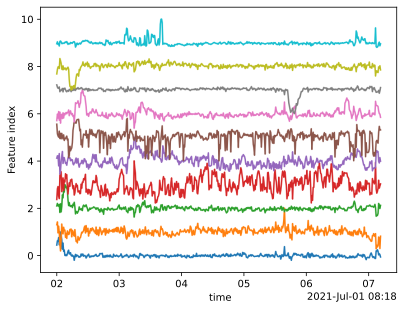

In [7]:
# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=200)
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel(" time")

# Show
plt.show()

#Les différentes couleurs que vous voyez correspondent à différentes caractéristiques 
#(ou dimensions) de vos données. Chaque ligne (ou couleur) 
#"représente une caractéristique différente au fil du temps.

In [8]:
# Load the scattering network
network = pickle.load(open("network/scattering_network.pickle", "rb"))

# Load the dimensionality reduction model
dimension_model = pickle.load(open("dimension_model.pickle", "rb"))

# Load data from file
with np.load("independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

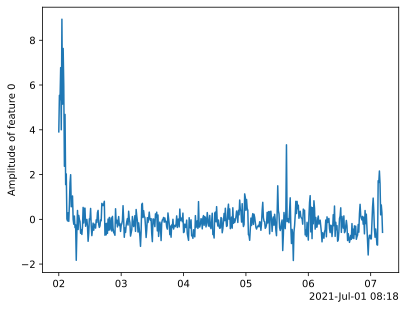

In [9]:
# Pick a feature
feature_id = 0
feature = features[:, feature_id]

# Figure creation
fig = plt.figure()
ax = plt.axes()

# Plot the weights
ax.plot(times, feature)
ax.set_ylabel(f"Amplitude of feature {feature_id}")

# Show
plt.show()

In [14]:
weights = dimension_model.components_[feature_id]
print(len(weights))


792


In [15]:
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
n_order_1

36

Ce code analyse comment différentes fréquences (ou autres caractéristiques extraites par le réseau de scattering) contribuent à une caractéristique particulière du modèle de réduction de dimensionnalité. Cela peut donner des insights sur la nature de la caractéristique en termes de fréquences ou d'autres mesures dans les données originales.

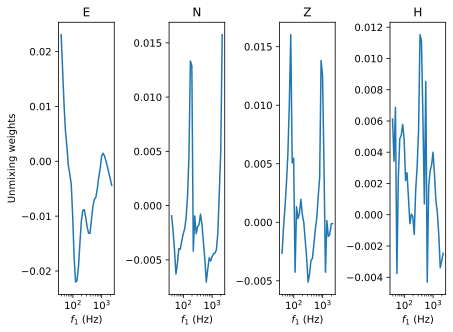

In [23]:
# Etract weights from the dimensionality reduction model
weights = dimension_model.components_[feature_id]
vmax = np.abs(weights).max()

# Scattering coefficients shape and frequencies
n_cha = 20
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
f_1 = network.banks[0].centers

# Extract and reshape weights
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)

# Show weights
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True)  # Modify number of rows to 1
for id, channel in enumerate("ENZH"):
    ax[id].plot(f_1, order_1[id], label=channel)
    ax[id].set_title(channel)
    ax[id].set_xlabel("$f_1$ (Hz)")

# Labels
ax[0].set_ylabel("Unmixing weights")
ax[0].set_xscale("log")

plt.tight_layout()
plt.show()


In [24]:
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)
print(len(order_1))

20


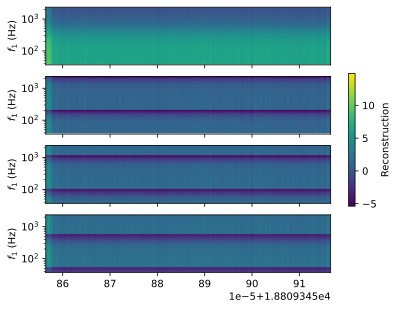

In [26]:
# Filter out latent space
import matplotlib.dates as mdates
features_filtered = np.zeros(features.shape)
features_filtered[:, feature_id] = feature

# Extract all scattering coefficients
reconstructed = dimension_model.inverse_transform(features_filtered)
reconstructed_order_1 = reconstructed[:, : n_cha * n_order_1].reshape(-1, n_cha, n_order_1)

# Check for object type and convert to float64 if necessary
if reconstructed_order_1.dtype == 'O':
    reconstructed_order_1 = reconstructed_order_1.astype(np.float64)

vmin = reconstructed_order_1.min()
vmax = reconstructed_order_1.max()
times_float = mdates.date2num(times)


# Plot
fig, ax = plt.subplots(nrows=4, sharex=True, sharey="row")

# Plot
for id, channel in enumerate("ENZH"):
    data = reconstructed_order_1[:, id, :].squeeze().T
    mappable = ax[id].pcolormesh(times_float, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)
    ax[id].set_ylabel("$f_1$ (Hz)")
    ax[id].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="vertical", ax=ax, shrink=0.5)
colorbar.set_label("Reconstruction")  # Modifié "Scattering coefficients" à "Reconstruction"


## clustering

In [27]:
# Load features and datetimes from file
with np.load("independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

# Load network
network = pickle.load(open("network/scattering_network.pickle", "rb"))

l'algorithme KMeans pour effectuer un clustering sur un ensemble de données représenté par la variable features

In [28]:
N_CLUSTERS = 10
from sklearn.cluster import KMeans

# Perform clustering
model = KMeans(n_clusters=N_CLUSTERS, n_init="auto", random_state=4)
model.fit(features)

# Predict cluster for each sample (Entraînement du Modèle)
predictions = model.predict(features)

C:\Users\cedri\anaconda3\envs\obspy\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


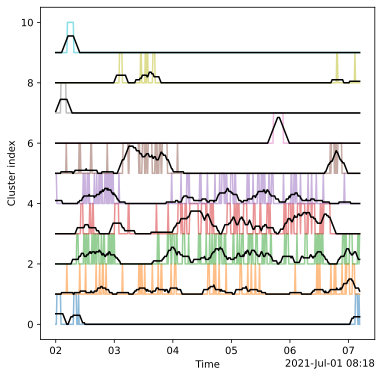

In [30]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")

plt.show()


La heatmap que vous avez partagée illustre les centroïdes pour chaque cluster identifié par l'algorithme KMeans.
Chaque ligne de la heatmap correspond à une caractéristique (feature index), et chaque colonne à un cluster spécifique (cluster index).
Les couleurs indiquent l'amplitude ou l'intensité de chaque caractéristique au sein de chaque cluster.

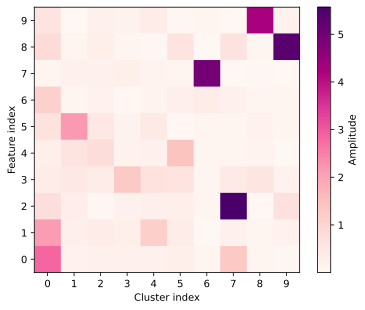

In [31]:
centroids = np.abs(model.cluster_centers_)

# Plot the centroids
fig = plt.figure()
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="RdPu")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Ticks below
ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(centroids.shape[1]))
ax.invert_yaxis()

# Show
plt.show()

In [32]:
N_WAVEFORMS = 5
import obspy

# Read the stream
stream = obspy.read("scattering_stream.mseed").select(channel="ZZZ")
waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    closest = times[predictions == cluster][distance.argsort()[:5]]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = obspy.UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy()
        traces.append(trace)
    waveforms.append(traces)

In [33]:
print("Shape of times:", times.shape)
print("Shape of predictions:", predictions.shape)
print("Shape of features:", features.shape)

Shape of times: (520,)
Shape of predictions: (520,)
Shape of features: (520, 10)


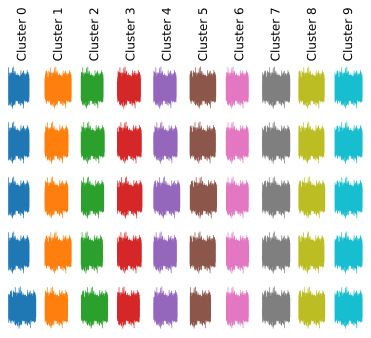

In [34]:
# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=300)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show()